# MNist using oscillation Hamiltonian Generative Flows



Let us remind ourselves of how Hamiltonian Generative Flows (HGF) work. We need to implement a Hamiltonian flow for a tuple of variables, a position variable $x(t)$ and a velocity variable $v(t)$. We call $\varphi(t) = (x(t), v(t))$ and
$$\frac{d\varphi}{dt} = (v(x, t), F(x, v, t))$$

We can fix $F(x, v, t)$ to be any value. For the oscillation HGF we set $F = -\alpha^2 x$ with $\alpha = 1$. The solution of the flow model for this equation of motion is
$$ (x_t, v_t) = \left(\cos(\alpha t)x + \frac{1}{\alpha}\sin(\alpha t)v, -\alpha\sin(\alpha t)x + \cos(\alpha t)v\right)$$

For this trajectory it can be seen that at $T = \pi/2$ we have $(x(T), v(T)) = \left(v, -x\right)$. This means $x(\pi / 2) \sim N(0, \mathbf{I}_d)$

To sample from the final point $T = \pi / 2$ we can sample from $x(\pi/2) \sim N(0, \mathbf{I}_d)$. We have to evolve the Hamilton flow backwards using the optimal velocity predictor, which minimizes the loss

$$L_v(\phi, t) = \mathbb{E}_{(x, v) \sim \Pi}\left[\left\lVert V_\phi(x_t, t) - v_t\right\rVert^2\right]$$

Once we have found this predictor we can solve the backwards equation using Euler integration to produce a generative model.

For the purposes of this notebook, we also want to be able to control the output. To do this we add a conditional variable on the generative model $V_\phi(x_t, t, y)$, where $y$ in this case is the MNist variable. We use classifier-free guidance to sample from this conditional velocity, with $y = 10$ being the null class.

See [1] for more details.

### Part 0: Miscellaneous Imports and Utility Functions

In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @property
    @abstractmethod
    def shape(self) -> list[int]:
        """
        Returns:
            - Shape of a sample of the distribution
        """
        pass

    @abstractmethod
    def sample(self, num_samples: int) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, shape[0], shape[1], ...)
            - classes: shape (batch_size, label_dim)
        """
        pass

class Gaussian(torch.nn.Module, Sampleable):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, std: float):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.mean = mean
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1))

    @property
    def shape(self) -> list[int]:
        return self.mean.shape

    @classmethod
    def isotropic(cls, shape: list[int], std: float) -> "Gaussian":
        mean = torch.zeros(shape)
        return cls(mean, std)

    def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device) + self.mean.to(self.dummy.device), None

### Part 1: Hamiltonian and Oscillation Probability Paths

In [3]:
class HamiltonianProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for Hamiltonian probability paths
    """
    def __init__(self, p_velocity: Sampleable, p_initial: Sampleable, p_final: Sampleable):
        super().__init__()
        self.p_initial = p_initial
        self.p_velocity = p_velocity
        self.p_final = p_final

    def sample_path(self, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Samples from the hamiltonian probability path
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        num_samples = t.shape[0]
        t = t.reshape(-1, 1, 1, 1)
        x_0, y_0 = self.p_initial.sample(num_samples)
        v_0, _ = self.p_velocity.sample(num_samples)
        return self.simulate_trajectory(x_0, v_0, t), y_0

    @abstractmethod
    def simulate_trajectory(self, x_0: torch.Tensor, v_0: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates the hamiltonian trajectory
        Args:
            - x_0: the inital value of x (num_samples, dim)
            - v_0: the initial value of v (num_samples, dim)
            - t: the timesteps (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        pass

    def sample_final(self, num_samples: int) -> torch.Tensor:
        """
        Samples from the final distribution p_final
        Args:
            - num_samples: Number of samples to generate
        Returns
            - x_T: the final value of x (num_samples, dim)
        """
        return self.p_final.sample(num_samples)

class OscillationProbabilityPath(HamiltonianProbabilityPath):
    """
    Class for Diffusion probability paths
    """
    def __init__(self, p_data: Sampleable):
        shape = p_data.shape
        epsilon = Gaussian.isotropic(shape=shape, std=1.0).to(device)
        p_final = Gaussian.isotropic(shape=shape, std=1.0).to(device)
        super().__init__(epsilon, p_data, p_final)

    def simulate_trajectory(self, x_0: torch.Tensor, v_0: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates the hamiltonian trajectory
        Args:
            - x_0: the inital value of x (num_samples, dim)
            - v_0: the initial value of v (num_samples, dim)
            - t: the timesteps (num_samples, 1)
        Returns:
            - x, v: samples from Pi(t), ((num_samples, dim), (num_samples, dim))
        """
        t = t.reshape(-1, 1, 1, 1)
        return torch.cos(t) * x_0 + torch.sin(t) * v_0, -torch.sin(t) * x_0 + torch.cos(t) * v_0

### Part 2: The ODE and backwards integrators.

In [4]:
class ODE(ABC):
    @abstractmethod
    def velocity(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, y: torch.Tensor, dt: torch.Tensor) -> torch.Tensor:
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - y: labels, shape (bs, label_dim)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
            - y: labels, shape (batch_size, label_dim)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, y, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
            - y: labels, shape (bs, label_dim)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, y, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, y: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        return xt + self.ode.velocity(xt, t, y) * h

def record_every(num_timesteps: int, record_every_num: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every_num parameter
    """
    if record_every_num == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every_num),
            torch.tensor([num_timesteps - 1]),
        ]
    )

### Part 3: The trainer and conditional velocity fields

In [5]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> int:
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    Args:
    - model: self-explanatory
    Returns:
    - size: model size in bytes
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Report model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')

        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs, device=device)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()

class ConditionalVectorField(nn.Module, ABC):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, c, h, w)
        """
        pass

class CFGVelocityFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField, guidance_scale: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale

    def velocity(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        """
        guided_vector_field = self.net(x, t, y)
        unguided_y = torch.ones_like(y) * 10
        unguided_vector_field = self.net(x, t, unguided_y)
        return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field

class CFGTrainer(Trainer):
    def __init__(self, path: HamiltonianProbabilityPath, model: ConditionalVectorField, eta: float, **kwargs):
        assert eta > 0 and eta < 1
        super().__init__(model, **kwargs)
        self.eta = eta
        self.path = path

    def get_train_loss(self, batch_size: int, T: float, device: torch.device) -> torch.Tensor:
        t = torch.rand(batch_size).to(device) * T

        (x, v), y = self.path.sample_path(t)

        mask = torch.rand(x.shape[0]) < self.eta
        y[mask] = 10

        v_theta = self.model.forward(x, t, y)

        return torch.mean((v - v_theta) ** 2)

### Part 4: The data sampler

In [6]:
class MNISTSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self):
        super().__init__()
        self.dataset = datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    @property
    def shape(self) -> list[int]:
        return [1, 32, 32]

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(*[self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy)
        labels = torch.tensor(labels, dtype=torch.int64).to(self.dummy.device)
        return samples, labels

### Part 5: The Velocity Model network

In [7]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        # Converts (bs, y_embed_dim) -> (bs, channels)
        self.y_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        res = x.clone() # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + t_embed

        # Add y embedding (conditional embedding)
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + y_embed

        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add back residual
        x = x + res # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class MNISTUNet(ConditionalVectorField):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, 1, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(nn.Conv2d(1, channels[0], kernel_size=3, padding=1), nn.BatchNorm2d(channels[0]), nn.SiLU())

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Initialize y embedder
        self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = y_embed_dim)

        # Encoders, Midcoders, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)

        # Final convolution
        self.final_conv = nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, 1, 32, 32)
        """
        # Embed t and y
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)
        y_embed = self.y_embedder(y) # (bs, y_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Midcoder
        x = self.midcoder(x, t_embed, y_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 32, 32)

        return x

### Part 6: Training

In [8]:
# Initialize probability path
path = OscillationProbabilityPath(
    p_data=MNISTSampler().to(device),
)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

# Train!
trainer.train(num_epochs = 1000, device=device, lr=1e-3, batch_size=250, T=np.pi / 2)

Training model with size: 4.715 MiB


Epoch 999, loss: 0.125: : 1000it [04:35,  3.63it/s]


### Part 7: Evaluation across each class

100%|██████████| 99/99 [00:05<00:00, 17.73it/s]


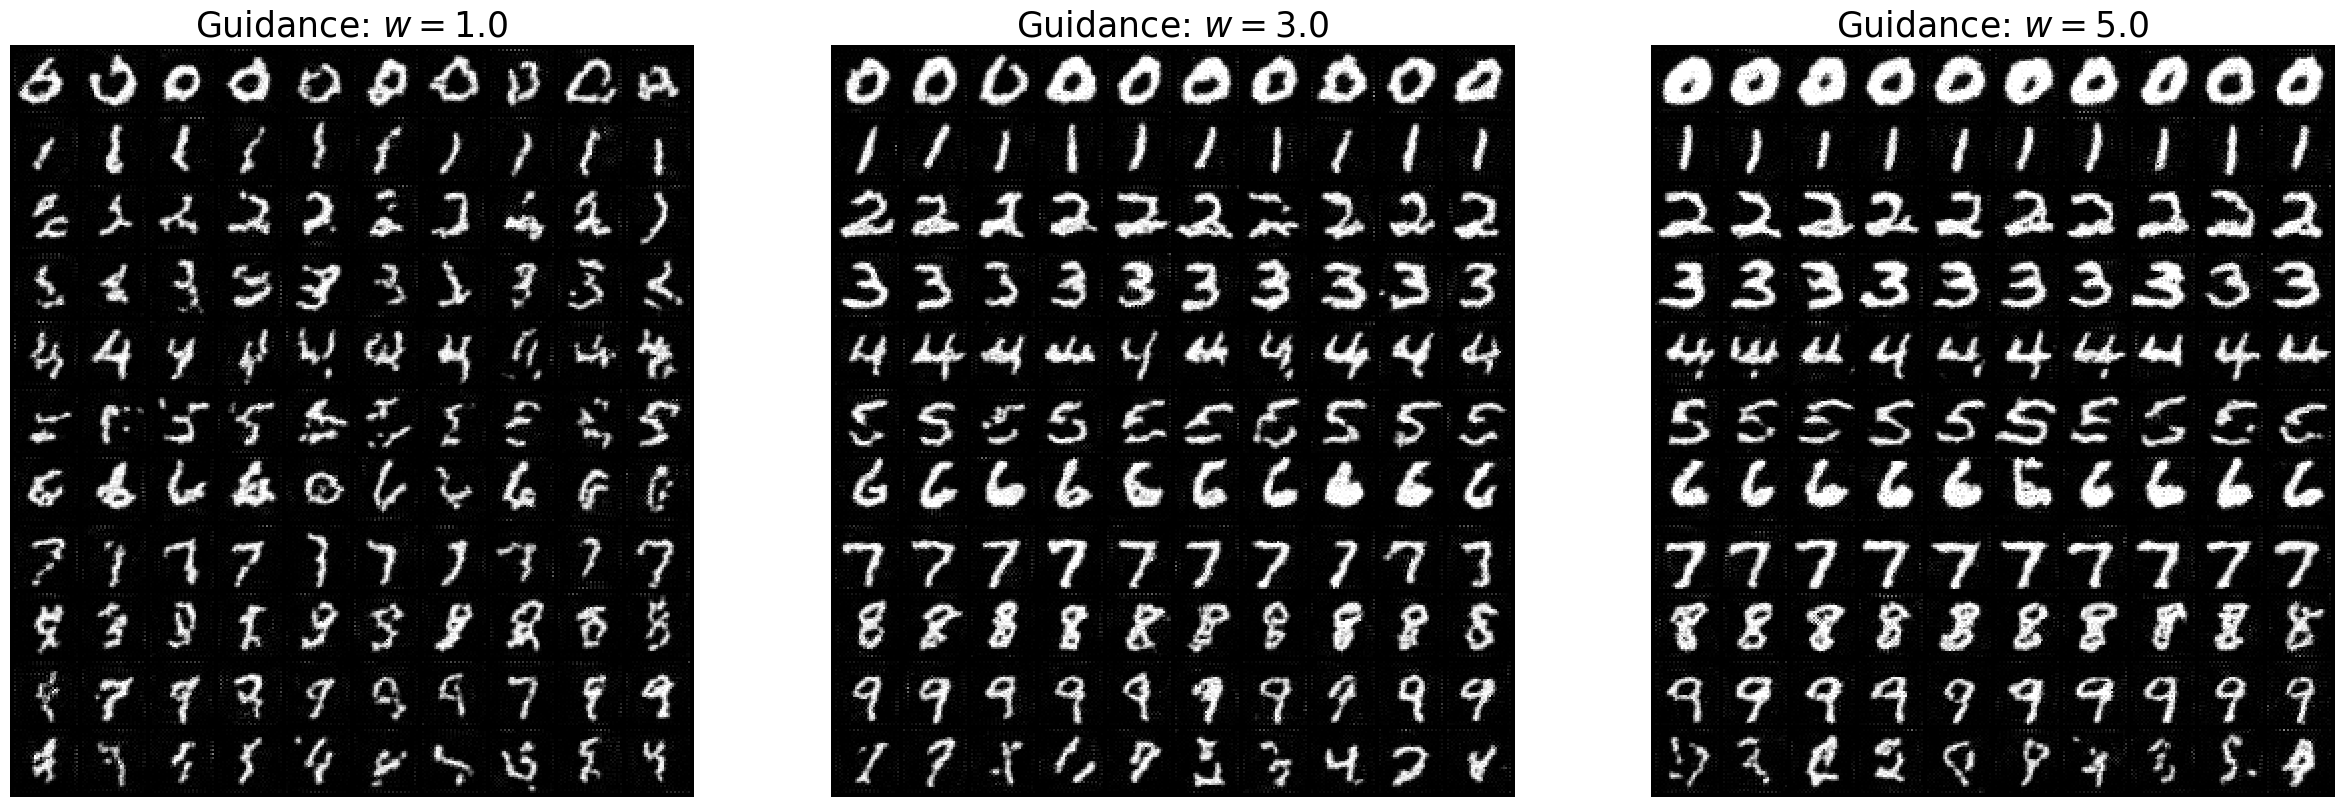

In [9]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]
T = np.pi / 2

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVelocityFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_final.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(T, 0, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()